<a href="https://colab.research.google.com/github/aryan1625/autograd/blob/main/autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class Value:
    def __init__(self,data,_children={},_op='',label=''):
      self.data = data
      self.grad = 0.0
      self._backward = lambda: None
      self._prev = set(_children)
      self._op = _op
      self.label = label


    def __repr__(self):
      return f"Value(data={self.data})"


    def __add__(self,other):
      other = other if isinstance(other,Value) else Value(other)
      out = Value(self.data+other.data,{self,other},'+','')
      def _backward():
        self.grad += 1.0*out.grad
        other.grad += 1.0*out.grad
      out._backward = _backward
      return out


    def __mul__(self,other):
      other = other if isinstance(other,Value) else Value(other)
      out = Value(self.data*other.data,{self,other},'*','')
      def _backward():
        self.grad += other.data*out.grad
        other.grad += self.data*out.grad
      out._backward = _backward
      return out

    def __rmul__(self, other):
      return self*other

    def __pow__(self,other):
      assert isinstance(other,(int,float))
      out = Value(self.data**other,(self,),f'**{other}')
      def backward():
        self.grad += other*(self.data**(other-1))*out.grad
      out._backward = backward
      return out


    def __truediv__(self,other):
      return self*(other**(-1))

    def __neg__(self):
      return self*-1

    def __sub__(self,other):
      return self+(-other)

    def __radd__(self,other):
      return self+other

    def exp(self):
      x = self.data
      out  = Value(math.exp(x),(self,),'exp')
      def backward():
        self.grad += out.data*out.grad
      return out


    def tanh(self):
      n = self.data
      t = math.exp(2*n)
      tf = (t-1)/(t+1)
      out  = Value(tf,(self,),'tanh')
      def _backward():
        self.grad += (1-tf**2)*out.grad
      out._backward = _backward
      return out


    def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)
      self.grad = 1.0
      for node in reversed(topo):
        node._backward()



In [ ]:
from graphviz import Digraph
def trace(root):
  nodes,edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges

def draw_dot(root):
  dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape='record')
    if n._op:
      dot.node(name=uid+n._op,label=n._op)
      dot.edge(uid+n._op,uid)
  for n1,n2 in edges:
    dot.edge(str(id(n1)),str(id(n2))+n2._op)
  return dot

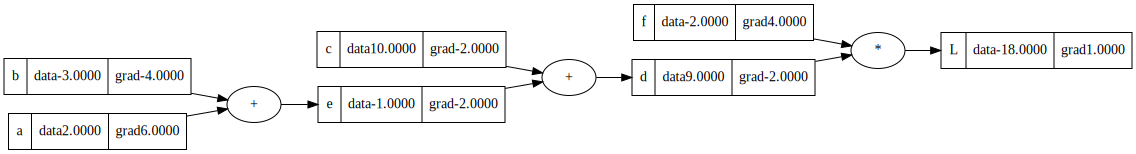

In [ ]:
draw_dot(L)

In [ ]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# o.grad = 1-o.data**2
# o.backward()

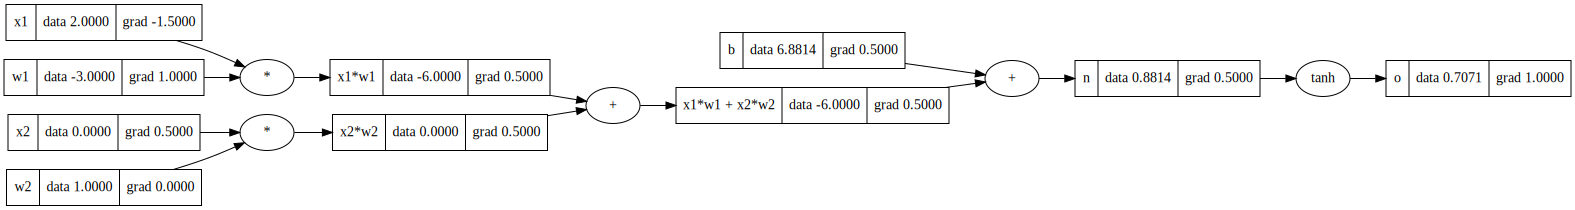

In [ ]:
draw_dot(o)

In [ ]:
import torch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1+x2*w2+b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
torch.tensor([[1,2,3],[4,5,6]])

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
import random
class Neuron:
    def __init__(self,nin):
      self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
      act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
      out = act.tanh()
      return out

    def parameters(self):
      return self.w+[self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self,nin,nouts):
    sz = [nin]+nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0,3,0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.6374854582710929)

In [ ]:
len(n.parameters())

41

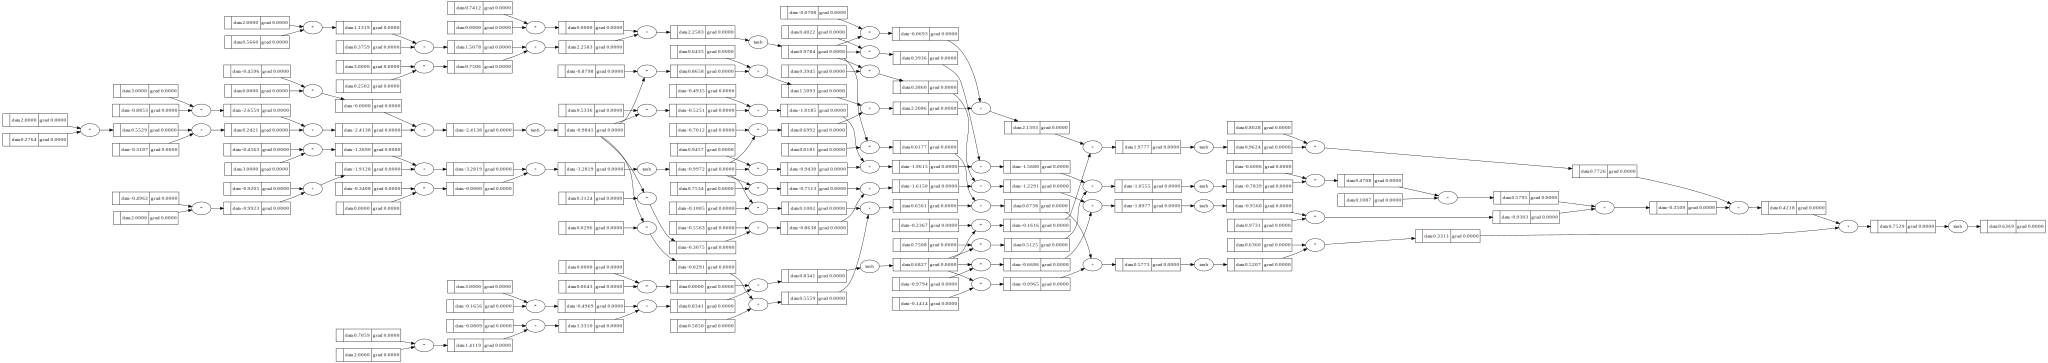

In [ ]:
draw_dot(n(x))

In [ ]:
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]]

ys = [1.0,-1.0,-1.0,1.0] #desired targets

In [ ]:
# loss = 0
# for i in range(len(ys)):
#   loss+= (ys[i]-ypred[i].data)**2
# loss
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)])
  #backward pass
  for p in n.parameters():
    p.grad=0.0
  loss.backward()
  #update
  for p in n.parameters():
    p.data += -0.01*p.grad
  print(k,loss.data,)


0 0.0027242777272252234
1 0.0027169110378442263
2 0.0027095982458019362
3 0.002702338721408091
4 0.002695131844852234
5 0.0026879770060101653
6 0.0026808736042547485
7 0.002673821048271248
8 0.0026668187558769804
9 0.0026598661538450867
10 0.0026529626777324574
11 0.0026461077717115714
12 0.0026393008884060785
13 0.0026325414887304675
14 0.002625829041733027
15 0.0026191630244425217
16 0.0026125429217183447
17 0.002605968226104106
18 0.0025994384376842043
19 0.0025929530639440574
